In [1]:
import sys
import logging
from uuid import UUID

import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt

logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)

iphone_ids = [UUID("079e0f1a-c440-3d7c-b0e7-de160f748e35"), UUID("c76a0487-7e5a-3b17-a449-47be666b36f6"), 
              UUID("c528bcd2-a88b-3e82-be62-ef4f2396967a")]
android_ids = [UUID("e471711e-bd14-3dbe-80b6-9c7d92ecc296"), UUID("fd7b4c2e-2c8b-3bfa-94f0-d1e3ecbd5fb7"),
               UUID("86842c35-da28-32ed-a90e-2da6663c5c73")]

In [2]:
#type: list of emission.storage.timeseries.builtin_timeseries.BuiltinTimeSeries
iphone_ts = map(lambda u: esta.TimeSeries.get_time_series(u), iphone_ids)
android_ts = map(lambda u: esta.TimeSeries.get_time_series(u), android_ids)

#time query specification
dt1 = pydt.datetime(2016, 6, 28, 0, 0) 
dt2 = pydt.datetime(2016, 6, 29, 8, 30)

ts1 = int(dt1.strftime("%s"))
ts2 = int(dt2.strftime("%s"))

time_range = estt.TimeQuery("metadata.write_ts", ts1, ts2)

#BuiltinTimeSeries.get_data_df(key, time_query = None, geo_query = None, extra_query_list=None) 
#type: list of DataFrame objects (regarding state info)
iphone_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), iphone_ts)
android_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), android_ts)

iphone_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), iphone_ts)
android_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), android_ts)

In [3]:
def get_ranges_df(battery_df, state_df):
    full_df = battery_df[battery_df.battery_level_pct == 100]
    if len(full_df) != 0:
        last_full_ts = full_df.iloc[-1].ts 
        start_ts = last_full_ts
    else: 
        start_ts = battery_df.iloc[0].ts
        
    charging_df = battery_df[battery_df.battery_status == 2]
    if len(charging_df) != 0:
        first_charging_ts = charging_df.iloc[0].ts
        end_ts = first_charging_ts
    else:
        end_ts = battery_df.iloc[-1].ts
    
    ranges_df = pd.DataFrame({'start_ts': [start_ts], 'end_ts': [end_ts]})
    return ranges_df

In [4]:
def get_ranges_df_list(battery_df_list, state_df_list):
    ranges_df_list = []
    length = len(battery_df_list)
    for i in range(0, length):
        ranges_df_list.append(get_ranges_df(battery_df_list[i], state_df_list[i]))
    return ranges_df_list

In [5]:
iphone_ranges_df_list = get_ranges_df_list(iphone_battery_df_list, iphone_state_df_list)

iphone_concat_ranges_df = pd.concat([iphone_ranges_df_list[0], iphone_ranges_df_list[1], iphone_ranges_df_list[2]])
iphone_concat_ranges_df

,end_ts,start_ts
0,1.467203e+09,1.467154e+09
0,1.467202e+09,1.467144e+09
0,1.467202e+09,1.467162e+09


In [6]:
android_ranges_df_list = get_ranges_df_list(android_battery_df_list, android_state_df_list)

android_concat_ranges_df = pd.concat([android_ranges_df_list[0], android_ranges_df_list[1], android_ranges_df_list[2]])
android_concat_ranges_df

,end_ts,start_ts
0,1.467194e+09,1.467103e+09
0,1.467193e+09,1.467099e+09
0,1.467194e+09,1.467101e+09


In [7]:
import arrow
iphone_start_ts = iphone_concat_ranges_df.start_ts.min() 
iphone_end_ts = iphone_concat_ranges_df.end_ts.min() 
i_t1 = arrow.get(iphone_start_ts).to('US/Pacific')
i_t2 = arrow.get(iphone_end_ts).to('US/Pacific')
print 'iphone_start_ts=' + str(i_t1) + '\n' + 'iphone_end_ts=' + str(i_t2)
print 'iphone_start_ts=' + str(iphone_start_ts) + '\n' + 'iphone_end_ts=' + str(iphone_end_ts)
print

android_start_ts = android_concat_ranges_df.start_ts.min() 
android_end_ts = android_concat_ranges_df.end_ts.min() 
a_t1 = arrow.get(android_start_ts).to('US/Pacific')
a_t2 = arrow.get(android_end_ts).to('US/Pacific')
print 'android_start_ts=' + str(a_t1) + '\n' + 'android_end_ts=' + str(a_t2)
print 'android_start_ts=' + str(android_start_ts) + '\n' + 'android_end_ts=' + str(android_end_ts)

iphone_start_ts=2016-06-28T13:00:24.261582-07:00
iphone_end_ts=2016-06-29T05:00:23.672472-07:00
iphone_start_ts=1467144024.26
iphone_end_ts=1467201623.67

android_start_ts=2016-06-28T00:34:05.811000-07:00
android_end_ts=2016-06-29T02:37:12.914000-07:00
android_start_ts=1467099245.81
android_end_ts=1467193032.91


In [8]:
import numpy as np

iphone_xnew = np.arange(iphone_start_ts, iphone_end_ts, 15 * 60) # 15 minutes
print len(iphone_xnew)

android_xnew = np.arange(android_start_ts, android_end_ts, 15 * 60) # 15 minutes
print type(android_xnew)

64
<type 'numpy.ndarray'>


In [9]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    #This class returns a function whose call method uses interpolation to find the value of new points.
    return fn(xnew)

In [10]:
#android4: read from battery_stats
battery_df = pd.read_csv("android4_remote_push.csv", error_bad_lines=False)
ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)
battery_df['local_dt'] = battery_df['ts'].apply(ts_to_dt)
android_battery_df_list.append(battery_df)

In [11]:
#iphone4: manually recorded battery status
dt0 = pydt.datetime(2016, 6, 28, 0, 30) 
dt1 = pydt.datetime(2016, 6, 28, 9, 23) 
dt2 = pydt.datetime(2016, 6, 28, 19, 42) 
dt3 = pydt.datetime(2016, 6, 29, 0, 31) 
dt4 = pydt.datetime(2016, 6, 29, 8, 22) 

#ts0 = int(dt0.strftime("%s"))
ts0 = iphone_start_ts
ts1 = int(dt1.strftime("%s"))
ts2 = int(dt2.strftime("%s"))
ts3 = int(dt3.strftime("%s"))
ts4 = int(dt4.strftime("%s"))

b0 = 100
b1 = 100
b2 = 99
b3 = 98
b4 = 95

ios4 = pd.DataFrame(data={'local_dt': [dt0, dt1, dt2, dt3, dt4], 'ts':[ts0, ts1, ts2, ts3, ts4],'battery_level_pct': [b0, b1, b2, b3, b4]})
ios4
iphone_battery_df_list.append(ios4)

#get_interpolated(ios4.ts, ios4.battery_level_pct, iphone_xnew)

In [12]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    #date.isoformat() Return a string representing the date in ISO 8601 format, ‘YYYY-MM-DD’. 
    # -For example, date(2002, 12, 4).isoformat() == '2002-12-04'.
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [13]:
iphone_battery_interp_df_list = map(lambda df: get_interpolated_df(df, iphone_xnew), iphone_battery_df_list)
android_battery_interp_df_list = map(lambda df: get_interpolated_df(df, android_xnew), android_battery_df_list)

In [14]:
label = ['10m', '30m', '1h', 'None']

About to plot 0
About to plot 1
About to plot 2


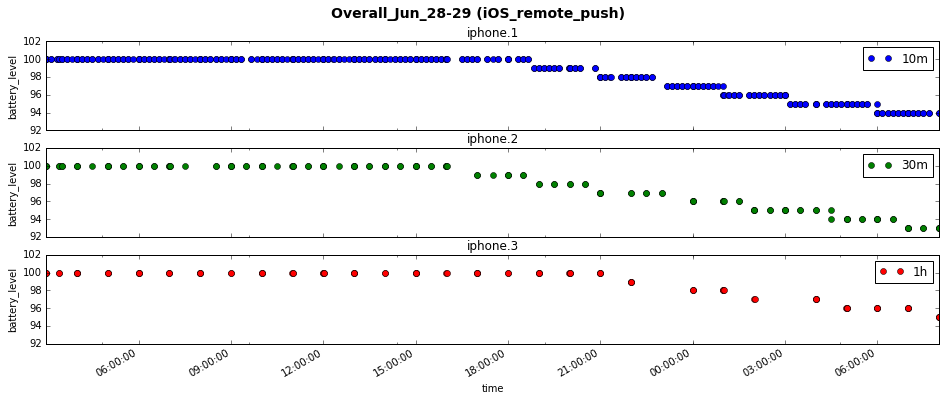

In [15]:
#iOS: No interplation on battery data
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=True, figsize=(16,6))
aaxes = aaxes2d.flatten()

afig.suptitle('Overall_Jun_28-29 (iOS_remote_push)', fontsize=14, fontweight='bold')
color = ['ob', 'og', 'or', 'oc']

for i, df in enumerate(iphone_battery_df_list):
    if i<>3: 
        print "About to plot %d" % i
        df['dt'] = df.ts.apply(ts_to_dt)
        df.plot(x='dt', y='battery_level_pct', style=color[i], ylim=(92, 102), ax=aaxes[i], title="iphone.%s" % (i+1), label=label[i])
        #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=aaxes[i], title="iphone.%s" % (i+1), label="iphone-%s" % (i+1), color=color[i])
        aaxes[i].set_xlabel('time')
        aaxes[i].set_ylabel('battery_level')
#afig.savefig('scatter_Jun28_29_iOS.png')

About to plot 0
About to plot 1
About to plot 2
About to plot 3
About to plot 0
About to plot 1
About to plot 2
About to plot 3


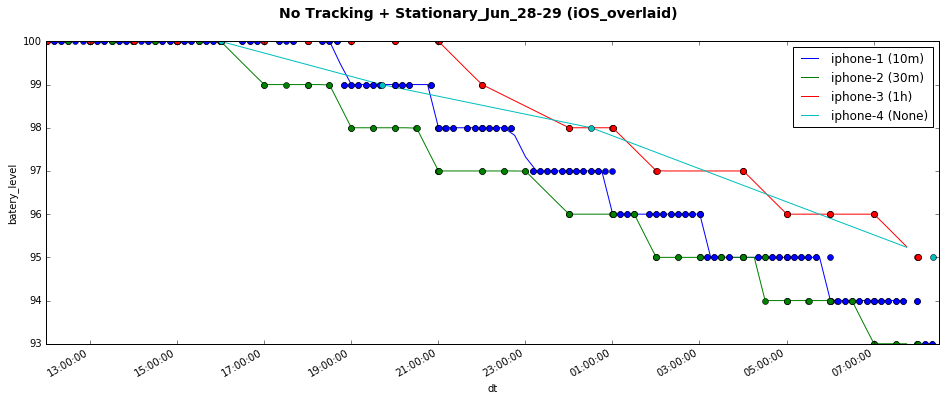

In [16]:
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
color = ['ob', 'og', 'or', 'oc']
ifig.suptitle('No Tracking + Stationary_Jun_28-29 (iOS_overlaid)', fontsize=14, fontweight='bold')

dt1 = pydt.datetime(2016, 6, 28, 12, 0) #datetime.datetime(2016, 6, 24, 22, 0)
dt2 = pydt.datetime(2016, 6, 29, 8, 30)

for i, df in enumerate(iphone_battery_interp_df_list):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=iaxes, xlim=(dt1, dt2), label=("iphone-%s " % (i+1))+'('+label[i]+')', legend=True)
    #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=iaxes, label="iOS-%s" % i, color=color[i])
    #iaxes.set_xlabel('time')
    iaxes.set_ylabel('batery_level')

for i, df in enumerate(iphone_battery_df_list):
    print "About to plot %d" % i
    df['dt'] = df.ts.apply(ts_to_dt)
    df.plot(x='dt', y='battery_level_pct', style=color[i], xlim=(dt1, dt2), ax=iaxes, legend=False)
    #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=aaxes[i], title="iphone.%s" % (i+1), label="iphone-%s" % (i+1), color=color[i])
    
ifig.savefig('overlaid_Jun28_29_iOS.png')  

[[ 1.          0.98024738  0.97029199  0.97824312]
 [ 0.98024738  1.          0.96457908  0.98320473]
 [ 0.97029199  0.96457908  1.          0.97212786]
 [ 0.97824312  0.98320473  0.97212786  1.        ]]


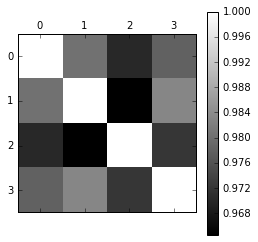

In [17]:
#iOS
#correlation analysis (tracking_off+stationary)
#generate list of iphone battery series 
iphone_battery_series_list = map(lambda b: b.battery_level_pct, iphone_battery_interp_df_list)
print np.corrcoef(iphone_battery_series_list)
plt.matshow(np.corrcoef(iphone_battery_series_list), cmap=plt.cm.gray)
plt.colorbar()

4
About to plot 0
About to plot 1
About to plot 2
About to plot 3


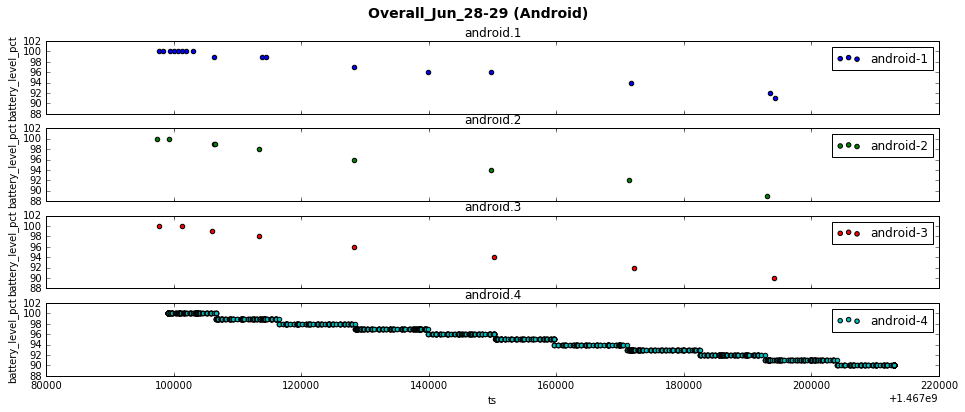

In [18]:
#Android: No interplation on battery data 
print len(android_battery_df_list)
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True, figsize=(16,6))
aaxes = aaxes2d.flatten()

afig.suptitle('Overall_Jun_28-29 (Android)', fontsize=14, fontweight='bold')
color = ['ob', 'og', 'or', 'oc']
c = ['b', 'g', 'r', 'c']

for i, df in enumerate(android_battery_df_list):
    print "About to plot %d" % i
    df['dt'] = df.ts.apply(ts_to_dt)
    #df.plot(x='dt', y='battery_level_pct', style=color[i], ax=aaxes[i], title="android.%s" % (i+1), label=label[i])
    df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=aaxes[i], title="android.%s" % (i+1), label="android-%s" % (i+1), color=c[i])
    
afig.savefig('scatter_Jun28_29_Android.png')

About to plot 0
About to plot 1
About to plot 2
About to plot 3
About to plot 0
About to plot 1
About to plot 2


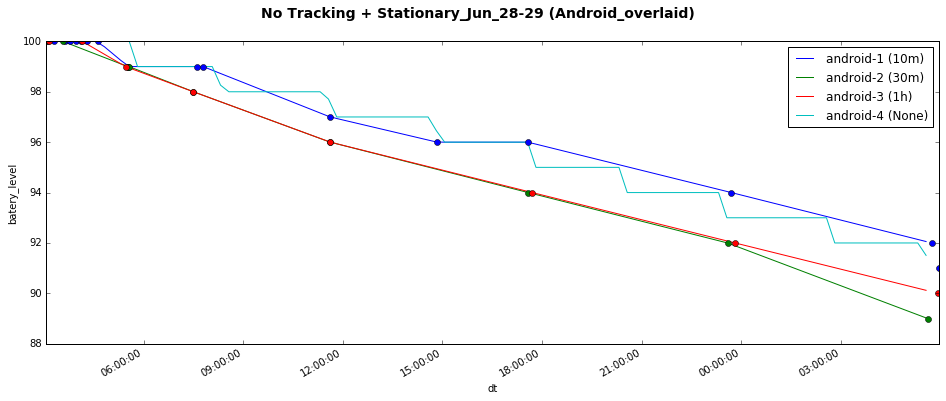

In [19]:
#Android: With interplation on battery data 
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
color = ['ob', 'og', 'or', 'oc']
ifig.suptitle('No Tracking + Stationary_Jun_28-29 (Android_overlaid)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=iaxes, label=("android-%s " % (i+1))+'('+label[i]+')', legend=True)
    #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=iaxes, label="Android-%s" % i, color=color[i])
    #iaxes.set_xlabel('time')
    iaxes.set_ylabel('batery_level')

for i, df in enumerate(android_battery_df_list):
    if i!= 3:
        print "About to plot %d" % i
        df.plot(x='dt', y='battery_level_pct', style=color[i], ax=iaxes, legend=False)
        #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=iaxes, label="Android-%s" % i, color=color[i])
        #iaxes.set_xlabel('time')
        iaxes.set_ylabel('batery_level')

ifig.savefig('overlaid_Jun28_29_Android.png')    

[[ 1.          0.9964653   0.99453201  0.98642181]
 [ 0.9964653   1.          0.99737146  0.99085305]
 [ 0.99453201  0.99737146  1.          0.98966224]
 [ 0.98642181  0.99085305  0.98966224  1.        ]]


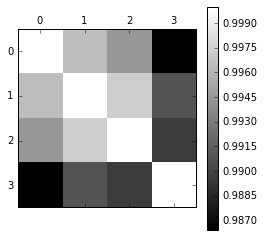

In [20]:
#Android 
#correlation analysis(tracking_off+stationary)
#generate list of android battery series 
android_battery_series_list = map(lambda b: b.battery_level_pct, android_battery_interp_df_list)
print np.corrcoef(android_battery_series_list)
plt.matshow(np.corrcoef(android_battery_series_list), cmap=plt.cm.gray)
plt.colorbar()